In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import random
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
torch.manual_seed(17)

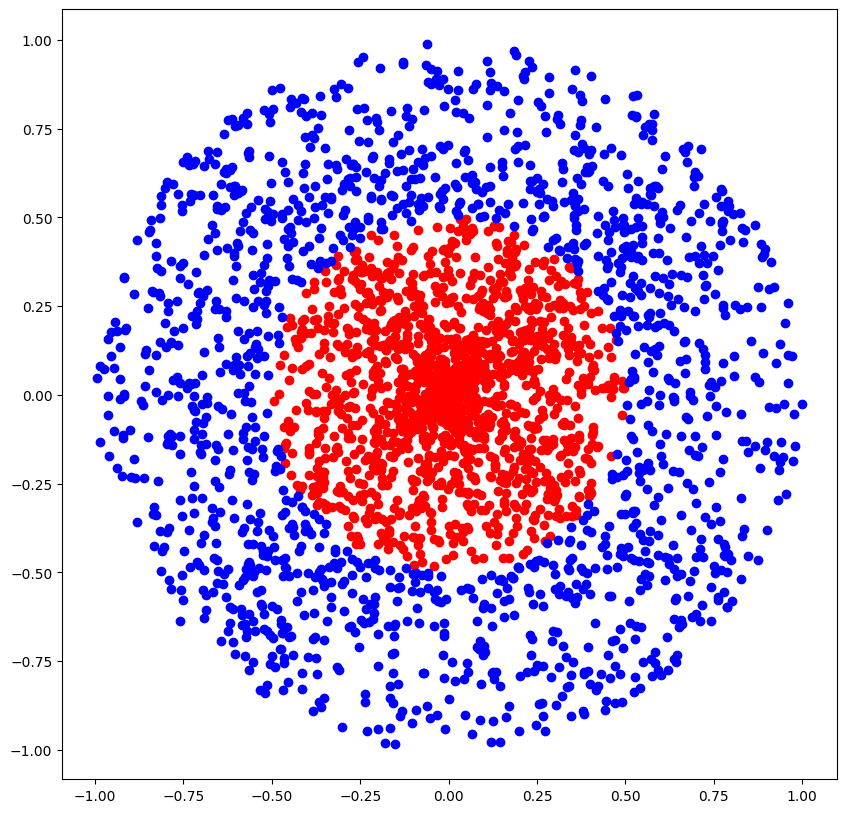

In [4]:
N = 3000
zz = np.zeros([N,2])
ll = np.zeros([N,1])

i = 0
fig, ax = plt.subplots(figsize=(10,10))

while i<N:
  if i<int(N/2):
    zz[i,:] = np.random.random(2)*2-1
    r = 0.5 * np.random.rand(1)
    zz[i,:]= r*zz[i,:]/np.linalg.norm(zz[i,:])
    ll[i] = np.array([0.])
    plt.scatter(zz[i,0],zz[i,1],color='red')
  else:
    zz[i,:] = np.random.random(2)*2-1
    r = 0.5 * (np.random.rand(1)+1)
    zz[i,:]= r*zz[i,:]/np.linalg.norm(zz[i,:])
    plt.scatter(zz[i,0],zz[i,1],color='blue')
    ll[i] = np.array([1.])
  i+=1

#Shuffle the points
import random
supp = np.arange(N)
random.shuffle(supp)
Points = zz[supp]
labels = ll[supp]

In [5]:
Ntrain = 2000

In [6]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.from_numpy(x.astype(np.float32)).to(device)
    self.y = torch.from_numpy(y.astype(np.float32)).to(device)
    self.length = self.x.shape[0]

  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

trainset = dataset(Points[:Ntrain,:],labels[:Ntrain])
testset = dataset(Points[Ntrain:,:], labels[Ntrain:])

In [7]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000,
                                          shuffle=True, num_workers=0)

In [8]:
class Network(nn.Module):
        def __init__(self):
            super(Network, self).__init__()

            self.nl = nn.Tanh()

            self.nlayers = 15
            self.T = 1.
            self.dt = self.T/self.nlayers
            self.linearsA = nn.ModuleList([nn.Linear(3, 3) for i in range(self.nlayers)])
            self.linearsB = nn.ModuleList([nn.Linear(3, 3, bias=False) for i in range(self.nlayers)])

            #self.last = nn.Linear(3,1)

        def layer(self,x,i):
          return x + self.dt * self.linearsB[i](self.nl(self.linearsA[i](x)))

        def forward(self, x):

          z = torch.zeros((len(x),1)).to(x.device)
          x = torch.cat((x,z),dim=1)

          for i in range(self.nlayers):
            x = self.layer(x,i)

          x = x[:,2:3] #self.last(x)

          return torch.sigmoid(x)

In [9]:
import torch.optim as optim

model = Network()
model.to(device)

criterion = nn.BCELoss()

epochs = 100
steps = epochs * len(trainloader)
max_lr = 1e-2
min_lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(),lr=min_lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
                        optimizer,
                        max_lr=max_lr,
                        div_factor= max_lr / min_lr,
                        total_steps=steps,
                        pct_start=0.4,
                        anneal_strategy="cos",
                    )

In [10]:
progress_bar = tqdm(range(epochs), desc="Training Progress", unit="epoch")

for _ in progress_bar:  # loop over the dataset multiple times

    running_loss = 0.0


    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

    correct = 0
    total = 0.

    with torch.no_grad():
      for data in testloader:
          points, labels = data
          # calculate outputs by running images through the network
          outputs = model(points.to(device))
          predicted = 1.*(outputs>0.5)
          total += labels.size(0)
          correct += (predicted == labels.to(device)).sum().item()

      formatted_accuracy = 100 * correct / total 
      progress_bar.set_postfix(test_accuracy=f"{formatted_accuracy:.2f}%")

print('Finished Training')

Training Progress: 100%|██████████| 100/100 [00:08<00:00, 11.36epoch/s, test_accuracy=99.50%]

Finished Training


In [11]:
model.eval();

In [12]:
X,Y = next(iter(testloader))

In [13]:
N = 2000
zz = np.zeros([N,2])
ll = np.zeros([N,1])

c = ['r','b']
outputs = model(X.to(device)).reshape(-1).detach().cpu().numpy()
predicted = (1*(outputs>0.5))

In [14]:
c = ['red','blue']
colors = [c[i] for i in predicted]

In [15]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from mpl_toolkits import mplot3d

In [16]:
updates = np.zeros((len(X),3,model.nlayers+1))
z = torch.zeros((len(X),1)).to(X.device)
res = torch.cat((X,z),dim=1)
updates[:,:,0] = res.detach().cpu().numpy()

for i in range(model.nlayers):
  res = model.layer(res,i)
  updates[:,:,i+1] = res.detach().cpu().numpy()

In [17]:
import matplotlib

In [18]:
matplotlib.rcParams['font.size']=20

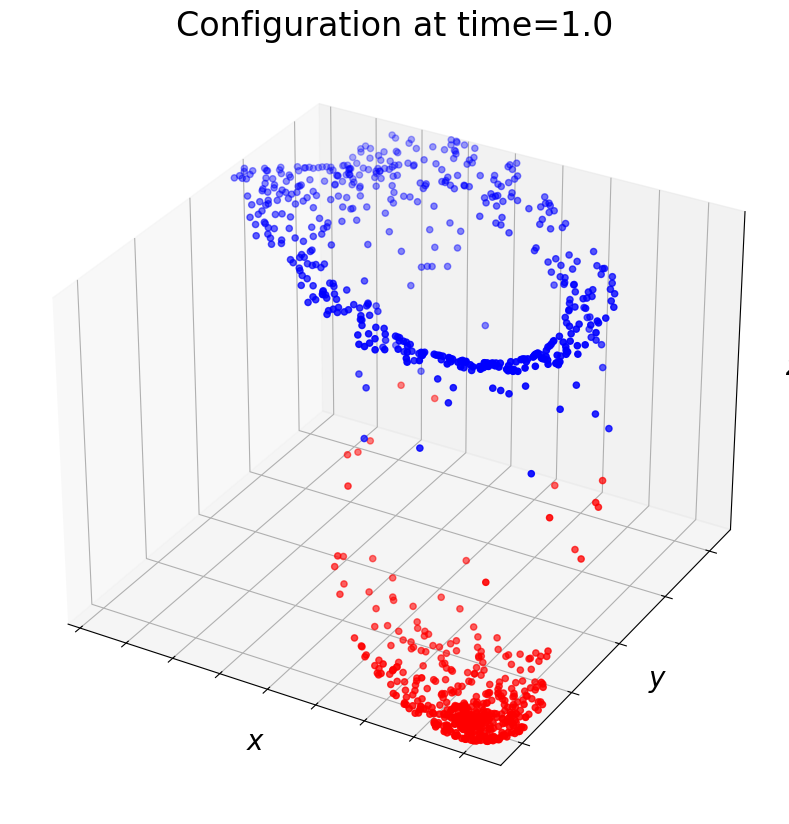

In [19]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
plt.xticks(color='w')
plt.yticks(color='w')
ax.set_zticks([])

def update_graph(i):

    graph._offsets3d = (updates[:,0,i], updates[:,1,i], updates[:,2,i])
    ax.title.set_text('Configuration at time={}'.format(np.round(i*model.dt,3)))

    if i>0:
      min_x = np.min(updates[:,0,i])
      max_x = np.max(updates[:,0,i])
      min_y = np.min(updates[:,1,i])
      max_y = np.max(updates[:,1,i])
      min_z = np.min(updates[:,2,i])
      max_z = np.max(updates[:,2,i])
      ax.set_xlim3d([min_x, max_x])
      ax.set_xlabel(r'$x$')
      ax.set_ylim3d([min_y, max_y])
      ax.set_ylabel(r'$y$')
      ax.set_zlim3d([min_z, max_z])
      ax.set_zlabel(r'$z$')
      ax.set_xticks([],minor=True)
      ax.set_yticks([],minor=True)
      ax.set_zticks([],minor=True)
graph = ax.scatter(updates[:,0,0], updates[:,1,0], updates[:,2,0],color=colors)

ani = matplotlib.animation.FuncAnimation(fig, update_graph, model.nlayers+1,
                               interval=40, blit=False)
ani.save("result.gif", writer='pillow',fps=1, dpi=600)
plt.show()